#***BUILD AN AI THAT SEES***#

##Load Dataset

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
cat_dog_classes = [3, 5]

In [ ]:
# Filter only cats and dogs
train_filter = np.isin(y_train, cat_dog_classes)
test_filter = np.isin(y_test, cat_dog_classes)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [ ]:
y_train = np.where(y_train == 3, 0, 1)
y_test = np.where(y_test == 5, 1, 0)

In [ ]:
# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

##Sample Visualization

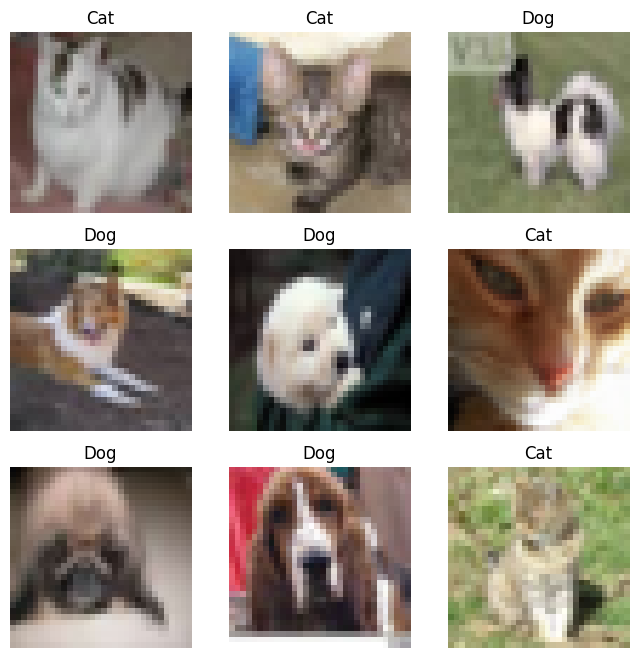

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Cat" if Y_train[i] == 0 else "Dog")
    plt.axis('off')
plt.show()

##Data Augmentation

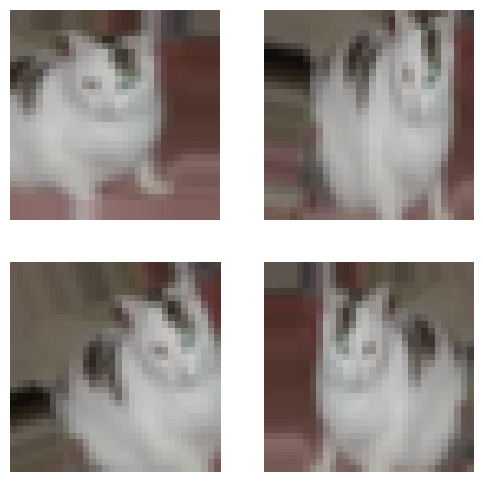

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Visualize augmented images
sample_img = X_train[0]
sample_img = np.expand_dims(sample_img, 0)
plt.figure(figsize=(6,6))
for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
    plt.subplot(2, 2, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    if i == 3:
        break
plt.show()


##Custom CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=32
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5319 - loss: 0.6889 - val_accuracy: 0.6275 - val_loss: 0.6463
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6559 - loss: 0.6227 - val_accuracy: 0.7075 - val_loss: 0.5581
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7096 - loss: 0.5617 - val_accuracy: 0.7225 - val_loss: 0.5390
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7423 - loss: 0.5157 - val_accuracy: 0.7510 - val_loss: 0.5089
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7785 - loss: 0.4699 - val_accuracy: 0.7530 - val_loss: 0.5061


##Evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

         Cat       0.71      0.85      0.78      1003
         Dog       0.82      0.65      0.72       997

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



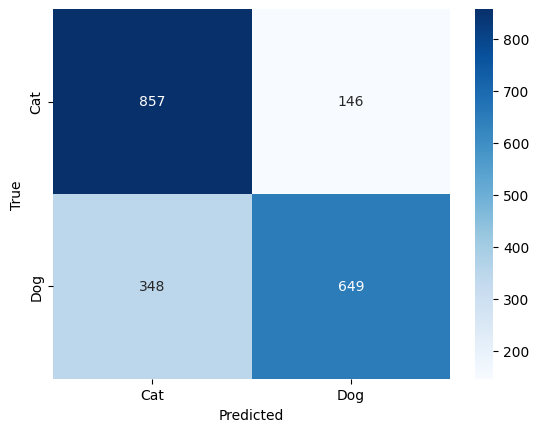

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = (model_cnn.predict(X_val) > 0.5).astype("int32")

print(classification_report(Y_val, y_pred, target_names=['Cat','Dog']))

cm = confusion_matrix(Y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


##Transfer Learning with MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
import cv2
X_train_resized = np.array([cv2.resize(img, (128, 128)) for img in X_train])
X_val_resized = np.array([cv2.resize(img, (128, 128)) for img in X_val])


##Preprocessing

In [ ]:
X_train_pre = preprocess_input(X_train_resized*255)
X_val_pre = preprocess_input(X_val_resized*255)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    X_train_pre, Y_train,
    validation_data=(X_val_pre, Y_val),
    epochs=3,
    batch_size=32
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.7782 - loss: 0.4564 - val_accuracy: 0.8680 - val_loss: 0.3113
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8748 - loss: 0.2927 - val_accuracy: 0.8630 - val_loss: 0.3396
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8977 - loss: 0.2416 - val_accuracy: 0.8815 - val_loss: 0.2854


##Evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy : 0.7475
Precision: 0.9393
Recall   : 0.5276
F1-score : 0.6757


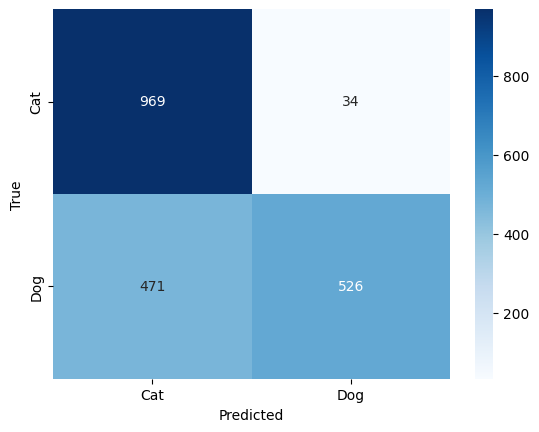


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      1003
           1       0.94      0.53      0.68       997

    accuracy                           0.75      2000
   macro avg       0.81      0.75      0.73      2000
weighted avg       0.81      0.75      0.73      2000



In [ ]:
import tensorflow as tf

# Resize validation data to 128x128 for MobileNetV2
X_val_resized = tf.image.resize(X_val, (128, 128))

# Predictions
mobilenet_probs = model_mobilenet.predict(X_val_resized)
mobilenet_preds = (mobilenet_probs > 0.5).astype("int32")

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(Y_val, mobilenet_preds)
precision = precision_score(Y_val, mobilenet_preds)
recall = recall_score(Y_val, mobilenet_preds)
f1 = f1_score(Y_val, mobilenet_preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_val, mobilenet_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_val, mobilenet_preds))


##Result Comparison

In [ ]:
print("\nCustom CNN Val Acc:", history_cnn.history['val_accuracy'][-1])
print("MobileNetV2 Val Acc:", history_mobilenet.history['val_accuracy'][-1])


Custom CNN Val Acc: 0.753000020980835
MobileNetV2 Val Acc: 0.8815000057220459


##ROC Curve & AUC

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


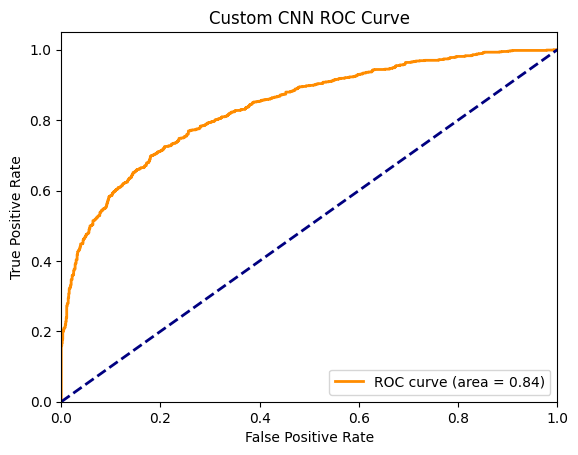

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for ROC
y_probs = model_cnn.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(Y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Custom CNN ROC Curve')
plt.legend(loc="lower right")
plt.show()


##F1-score Plot

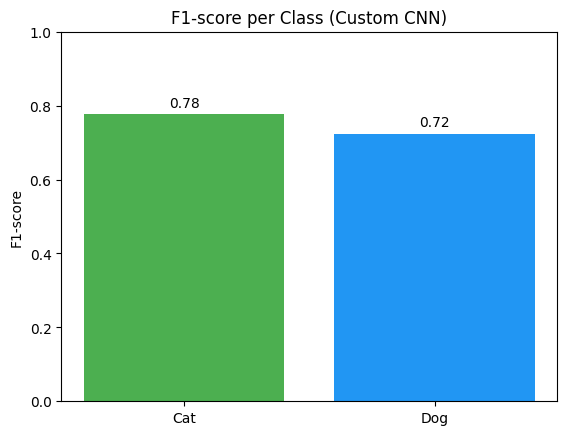

In [ ]:
from sklearn.metrics import f1_score

# Compute F1 per class
f1_cat = f1_score(Y_val, y_pred, pos_label=0)
f1_dog = f1_score(Y_val, y_pred, pos_label=1)

plt.bar(['Cat', 'Dog'], [f1_cat, f1_dog], color=['#4CAF50', '#2196F3'])
plt.ylim(0, 1)
plt.title('F1-score per Class (Custom CNN)')
plt.ylabel('F1-score')
for i, score in enumerate([f1_cat, f1_dog]):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
plt.show()

###Performance Curve###

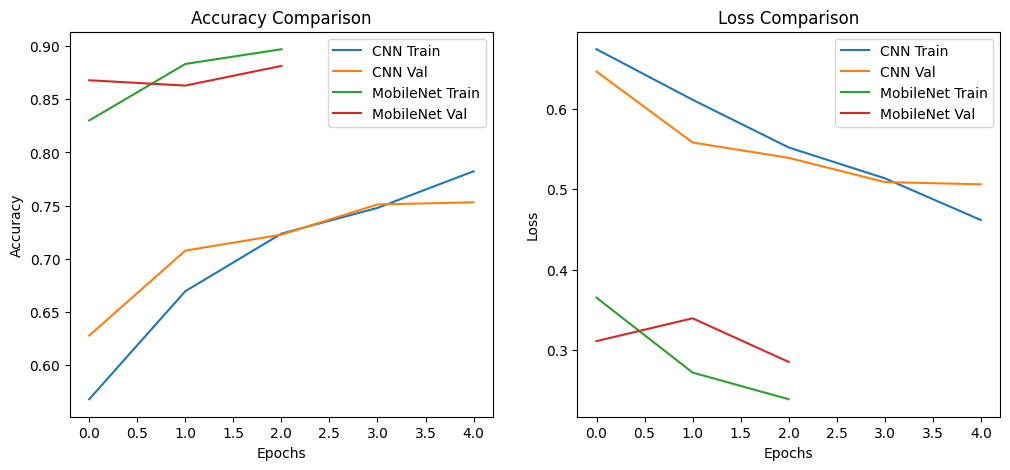

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy curves
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNet Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNet Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curves
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='CNN Train')
plt.plot(history_cnn.history['val_loss'], label='CNN Val')
plt.plot(history_mobilenet.history['loss'], label='MobileNet Train')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNet Val')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
